In [1]:
!pip3 install tensorflow==2.11.*


Defaulting to user installation because normal site-packages is not writeable


In [2]:
! pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


## This is Lunar Model developed for segmentaion of the rocks with the surface of moon, the images used in the training dataset are not real but generated using the software- Planetside Software's Terragen. 
### It can be found at the link -- https://www.kaggle.com/datasets/romainpessia/artificial-lunar-rocky-landscape-dataset

In [3]:
import os
import cv2
import tensorflow as tf
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
sm.set_framework('tf.keras')
import glob
import numpy as np
from matplotlib import pyplot as plt
import keras 
from sklearn.model_selection import train_test_split
keras.backend.set_image_data_format('channels_last')

2023-03-17 01:10:27.681248: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 01:10:31.762278: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/u188077/.local/lib/python3.9/site-packages/cv2/../../lib64:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/vpl/2023.0.0/lib:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/tbb/2021.8.0/env/../lib/intel64/gcc4.8:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/rkcommon/1.10.0/lib:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/ospray_studio/0.11.1/lib

Segmentation Models: using `tf.keras` framework.


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Data PreProcessing PipeLine

In [4]:
H = 256 # height of image
W = 256 # width of image

'''This function is used to return the list of path for images and masks in
sorted order from the given directory respectively.'''
# function to return list of image paths and mask paths 
def process_data(IMG_DIR, MASK_DIR):
    images = [os.path.join(IMG_DIR, x) for x in sorted(os.listdir(IMG_DIR))]
    masks = [os.path.join(MASK_DIR, x) for x in sorted(os.listdir(MASK_DIR))]

    return images, masks

'''This function is used to return splitted list of images and corresponding 
mask paths in train and test by providing test size.'''
# function to load data and train test split
def load_data(IMG_DIR, MASK_DIR):
    X, y = process_data(IMG_DIR, MASK_DIR)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

'''This function is used to read images. It takes image path as input. 
After reading image it is resized by width and height provide above(256 x 256). 
Next normalization is done by dividing each values with 255. And the result is returned.'''
# function to read image
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

'''This function is used to read masks.'''
# function to read mask
def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x.astype(np.int32)
    return x

'''This function is used to generate tensorflow data pipeline. 
The tensorflow data pipeline is mapped to function ‘preprocess’ .'''
# function for tensorflow dataset pipeline
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset

'''This function takes image and mask path. 
It reads the image and mask as provided by paths. 
Mask is one hot encoded for multi class segmentation (here 4 class).'''
# function to read image and mask amd create one hot encoding for mask
def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        image = read_image(x)
        mask = read_mask(y)

        return image, mask

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.int32])
    mask = tf.one_hot(mask, 4, dtype=tf.int32)
    image.set_shape([H, W, 3])
    mask.set_shape([H, W, 4])

    return image, mask

# Load the DATA

In [5]:
'''RENDER_IMAGE_DIR_PATH: ‘Path of image directory’
GROUND_MASK_DIR_PATH: ‘Path of mask directory’


Here load_data function is called. This will load the dataset paths and 
split it into X_train, X_test, y_train, y_test '''

RENDER_IMAGE_DIR_PATH = "..//oneAPI-samples//dataset//images//clean"
GROUND_MASK_DIR_PATH = "..//oneAPI-samples//dataset//images//render"

X_train, X_test, y_train, y_test = load_data(RENDER_IMAGE_DIR_PATH, GROUND_MASK_DIR_PATH)
print(f"Dataset:\n Train: {len(X_train)} \n Test: {len(X_test)}")

Dataset:
 Train: 7812 
 Test: 1954


# Generate TensorFlow Data PipeLine

In [6]:
batch_size = 8

'''Here the tf_dataset function is called will generate the tensorflow data pipeline.'''
# calling tf_dataset
train_dataset = tf_dataset(X_train, y_train, batch=batch_size)
valid_dataset = tf_dataset(X_test, y_test, batch=batch_size)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-03-17 01:12:14.072794: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/u188077/.local/lib/python3.9/site-packages/cv2/../../lib64:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/vpl/2023.0.0/lib:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/tbb/2021.8.0/env/../lib/intel64/gcc4.8:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/rkcommon/1.10.0/lib:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/ospray_studio/0.11.1/lib:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/ospray/2.10.0/lib:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/openvkl/1.3.1/lib:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/oidn/1.4.3/lib:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/mpi/2021.8.0//libfabric/lib:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/

# Creating U-Net Architecture

In [7]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

'''conv_block it is used to create one block with two convolution layer 
followed by BatchNormalization and activation function relu. 
If the pooling is required then Maxpool2D is applied and return it else not.'''
# function to create convolution block
def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x

'''build_unet it is used to create the U-net architecture.'''
# function to build U-net
def build_unet(shape, num_classes):
    inputs = Input(shape)

    """ Encoder """
    x1, p1 = conv_block(inputs, 16, pool=True)
    x2, p2 = conv_block(p1, 32, pool=True)
    x3, p3 = conv_block(p2, 48, pool=True)
    x4, p4 = conv_block(p3, 64, pool=True)

    """ Bridge """
    b1 = conv_block(p4, 128, pool=False)

    """ Decoder """
    u1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool=False)

    u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool=False)

    u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool=False)

    u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool=False)

    """ Output layer """
    output = Conv2D(num_classes, 1, padding="same", activation="softmax")(x8)

    return Model(inputs, output)

In [8]:
# calling build_unet function
model = build_unet((256, 256, 3), 4)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

# Load Model And Compile

In [11]:
# importing libraries
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from segmentation_models.metrics import iou_score
import datetime, os

""" Hyperparameters """
img_shape = (256, 256, 3)
num_classes = 4
lr = 1e-3
batch_size = 16
epochs = 6

""" Model """
model = build_unet(img_shape, num_classes)
model.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(lr), 
              metrics=[iou_score])


train_steps = len(X_train)//batch_size
valid_steps = len(X_test)//batch_size

# Train Model

In [12]:
'''model.fit is used to train the model'''
model_history = model.fit(train_dataset,
        steps_per_epoch=train_steps,
        validation_data=valid_dataset,
        validation_steps=valid_steps,
        epochs=epochs,
    )

Epoch 1/6
488/488 [==============================] - 846s 2s/step - loss: 0.1113 - iou_score: 0.1210 - val_loss: 0.0966 - val_iou_score: 0.1301
Epoch 2/6
488/488 [==============================] - 815s 2s/step - loss: 0.0896 - iou_score: 0.1127 - val_loss: 0.0673 - val_iou_score: 0.1009
Epoch 3/6
488/488 [==============================] - 791s 2s/step - loss: 0.0749 - iou_score: 0.1044 - val_loss: 0.0599 - val_iou_score: 0.0913
Epoch 4/6
488/488 [==============================] - 790s 2s/step - loss: 0.0817 - iou_score: 0.1002 - val_loss: 0.0645 - val_iou_score: 0.0963
Epoch 5/6
488/488 [==============================] - 791s 2s/step - loss: 0.0770 - iou_score: 0.0997 - val_loss: 0.0725 - val_iou_score: 0.1039
Epoch 6/6
488/488 [==============================] - 790s 2s/step - loss: 0.0693 - iou_score: 0.1001 - val_loss: 0.0644 - val_iou_score: 0.0968


# Save Model

In [14]:
from tensorflow.keras.models import save_model


In [15]:
save_model(model, "model.h5")

In [ ]:
# from tensorflow.keras.models import load_model
# model = load_model('model.h5')             in order to load the model

# Predict From Model

In [16]:
# function to predict result 
def predict_image(img_path, mask_path, model):
    H = 256
    W = 256
    num_classes = 4

    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (W, H))
    img = img / 255.0
    img = img.astype(np.float32)

    ## Read mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (W, H))   ## (256, 256)
    mask = np.expand_dims(mask, axis=-1) ## (256, 256, 1)
    mask = mask * (255/num_classes)
    mask = mask.astype(np.int32)
    mask = np.concatenate([mask, mask, mask], axis=2)

    ## Prediction
    pred_mask = model.predict(np.expand_dims(img, axis=0))[0]
    pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = np.expand_dims(pred_mask, axis=-1)
    pred_mask = pred_mask * (255/num_classes)
    pred_mask = pred_mask.astype(np.int32)
    pred_mask = np.concatenate([pred_mask, pred_mask, pred_mask], axis=2)

    return img, mask, pred_mask

In [17]:
# function to display result
def display(display_list):
  plt.figure(figsize=(12, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask', 'Mask On Image']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

1/1 [==============================] - 0s 78ms/step


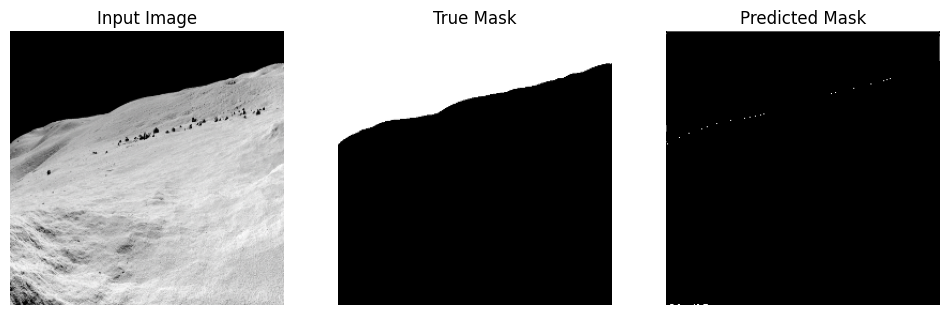

In [19]:
img_path = "..//oneAPI-samples//dataset//images//render//render0004.png"
mask_path = "..//oneAPI-samples//dataset//images//clean//clean0004.png"

img, mask, pred_mask = predict_image(img_path, mask_path, model)

display([img, mask, pred_mask])